#Data Loading

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
import shap

#load datasets
datetimeevents = pd.read_csv('/mmfs1/project/mx6/sp3463/MIMIC-IV/icuunzipped/datetimeevents.csv')
chartevents = pd.read_csv('/mmfs1/project/mx6/sp3463/MIMIC-IV/icuunzipped/chartevents.csv')
labevents = pd.read_csv('/mmfs1/project/mx6/sp3463/MIMIC-IV/hospunzipped/labevents.csv')
d_items = pd.read_csv('/mmfs1/project/mx6/sp3463/MIMIC-IV/icuunzipped/d_items.csv')
d_labitems = pd.read_csv('/mmfs1/project/mx6/sp3463/MIMIC-IV/hospunzipped/d_labitems.csv')
admissions = pd.read_csv('/mmfs1/project/mx6/sp3463/MIMIC-IV/hospunzipped/admissions.csv')
patients = pd.read_csv('/mmfs1/project/mx6/sp3463/MIMIC-IV/hospunzipped/patients.csv')

In [ ]:
#filter relevant vitals from chartevents using d_items
relevant_items = d_items[d_items['label'].str.contains('heart rate|blood pressure|temperature', case=False)]
filtered_chartevents = chartevents[chartevents['itemid'].isin(relevant_items['itemid'])]

#join with metadata for labels
filtered_chartevents = filtered_chartevents.merge(d_items[['itemid', 'label']], on='itemid', how='left')

#join with patient and admission details
chartevents_with_context = filtered_chartevents.merge(admissions, on=['subject_id', 'hadm_id'], how='left')
chartevents_with_context = chartevents_with_context.merge(patients, on='subject_id', how='left')

#select relevant columns
vitals_data = chartevents_with_context[['subject_id', 'hadm_id', 'label', 'valuenum', 'valueuom', 'gender', 'anchor_age', 'admission_type', 'hospital_expire_flag']]

missing_values = vitals_data.isnull().sum()
print("Length of dataset: ", len(vitals_data))
print("Missing Values:")
print(missing_values)

print("Missing percentage:")
#calculate missing percentages for each column
missing_percentage = vitals_data.isnull().mean() * 100
print(missing_percentage)


Length of dataset:  70413
Missing Values:
subject_id                 0
hadm_id                    0
label                      0
valuenum                5816
valueuom                5816
gender                     0
anchor_age                 0
admission_type             0
hospital_expire_flag       0
dtype: int64
Missing percentage:
subject_id              0.000000
hadm_id                 0.000000
label                   0.000000
valuenum                8.259838
valueuom                8.259838
gender                  0.000000
anchor_age              0.000000
admission_type          0.000000
hospital_expire_flag    0.000000
dtype: float64


In [ ]:
vitals_data

,subject_id,hadm_id,label,valuenum,valueuom,gender,anchor_age,admission_type,hospital_expire_flag
0,10005817,20626031,Heart Rate Alarm - Low,55.0,bpm,M,66,URGENT,0
1,10005817,20626031,Heart rate Alarm - High,120.0,bpm,M,66,URGENT,0
2,10005817,20626031,Arterial Blood Pressure diastolic,37.0,mmHg,M,66,URGENT,0
3,10005817,20626031,Temperature Celsius,37.0,°C,M,66,URGENT,0
4,10005817,20626031,Arterial Blood Pressure Alarm - High,140.0,mmHg,M,66,URGENT,0
...,...,...,...,...,...,...,...,...,...
70408,10019003,29279905,Heart Rate,99.0,bpm,F,65,EW EMER.,0
70409,10019003,29279905,Temperature Fahrenheit,97.8,°F,F,65,EW EMER.,0
70410,10019003,29279905,Non Invasive Blood Pressure diastolic,62.0,mmHg,F,65,EW EMER.,0
70411,10019003,29279905,Non Invasive Blood Pressure systolic,118.0,mmHg,F,65,EW EMER.,0


In above cell we can see that mostly the columns don't have missing values, but valuenum and valueuom have 5816 missing. However, this is still less than 10% of the data, so rather than dropping the column, we can benefit from imputting this column with mean as this is an important feature and only a small percentage of the record data is missing. However, we need to pivot the data beforehand as the labels in the dataset actually consists of vitals of patients, with each patients having multiple records with their respective labels which are patient's vitals with valuenum being the recording of the vital and valueuom being the measure. Let's first see the distribution of the labels, and then we can convert the label column into independent features via pivotting labels into columns.

##Data Distribution

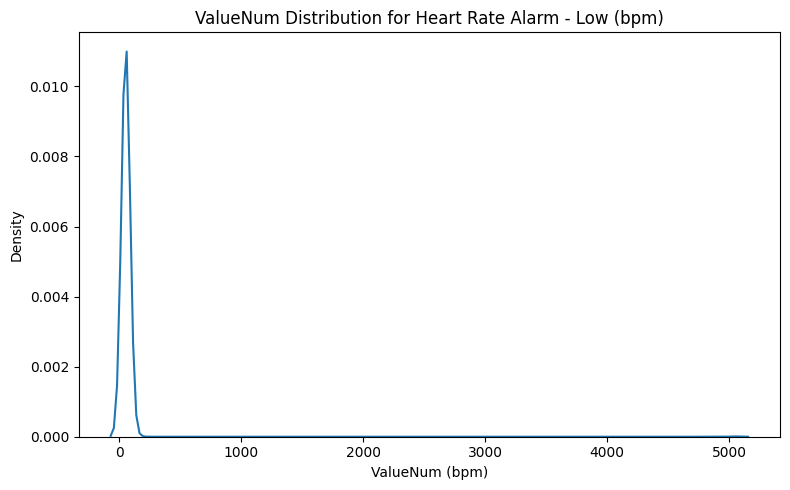

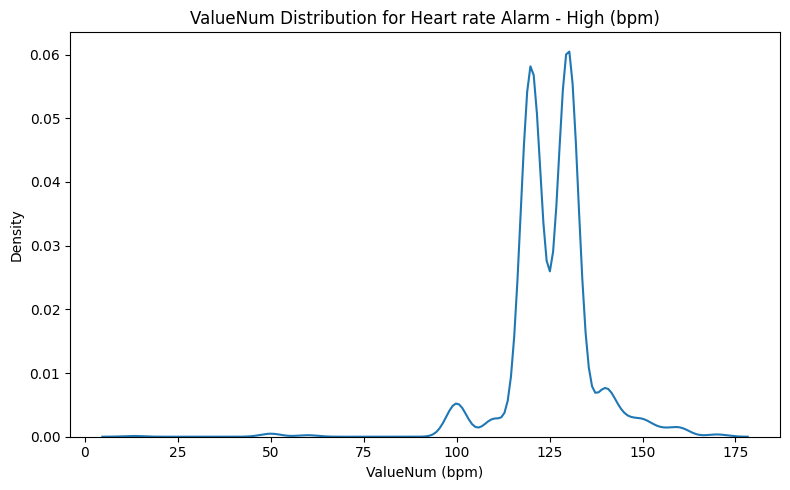

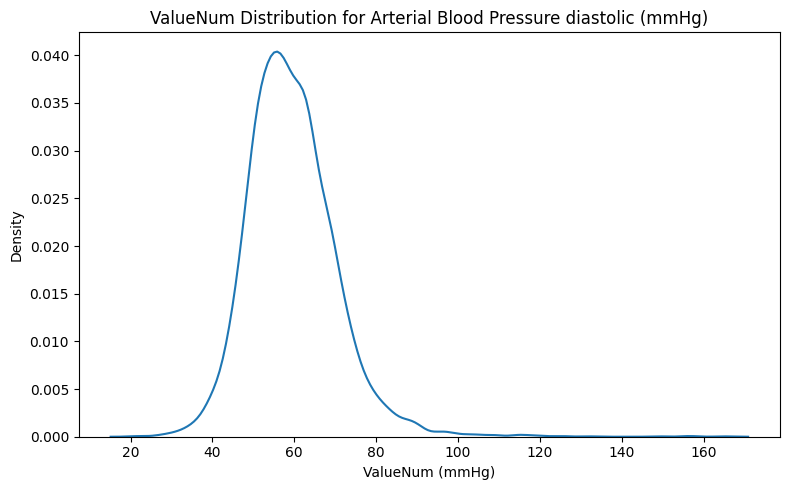

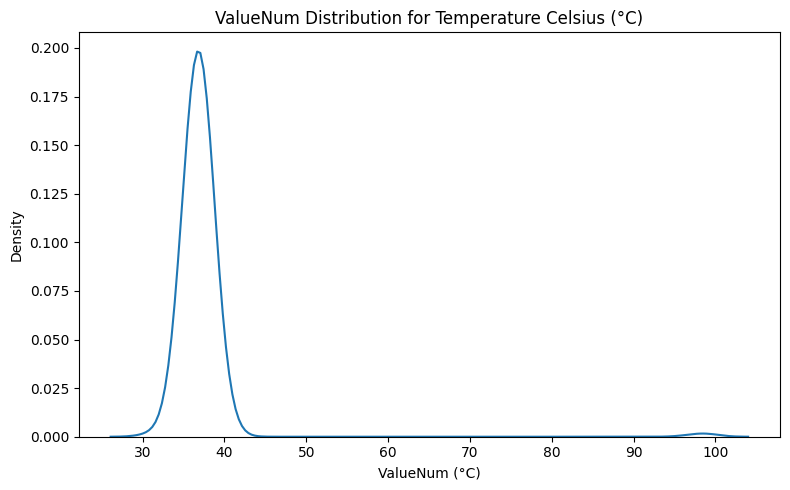

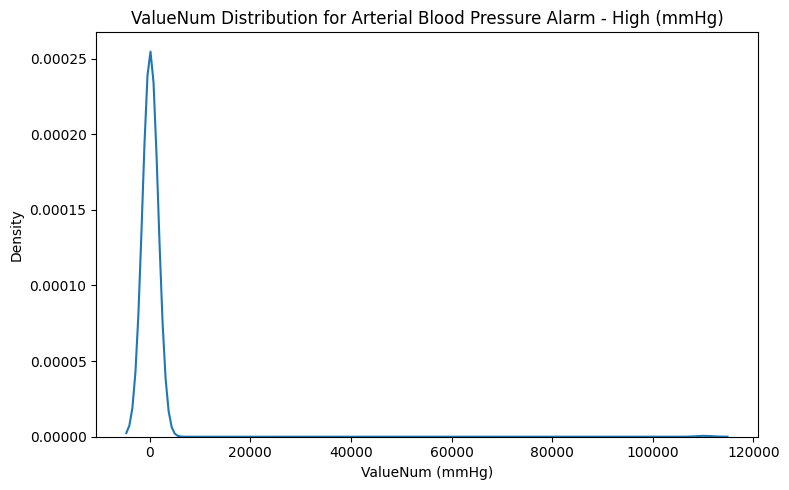

/tmp/ipykernel_2778127/2888883709.py:7: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(subset['valuenum'])


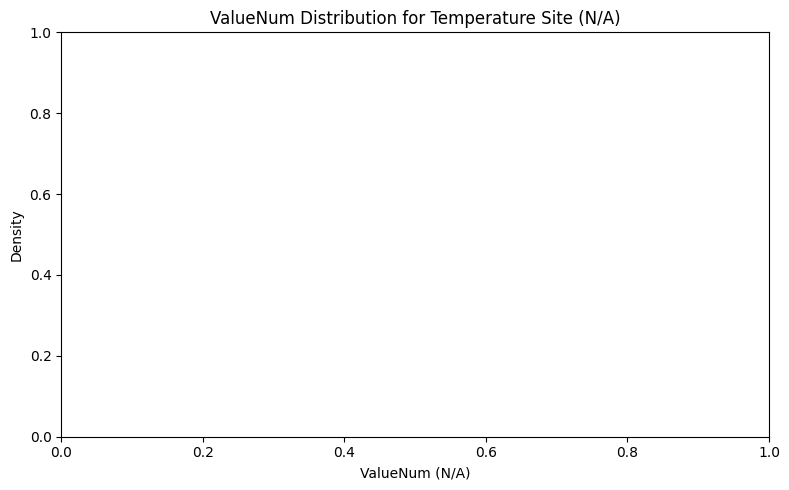

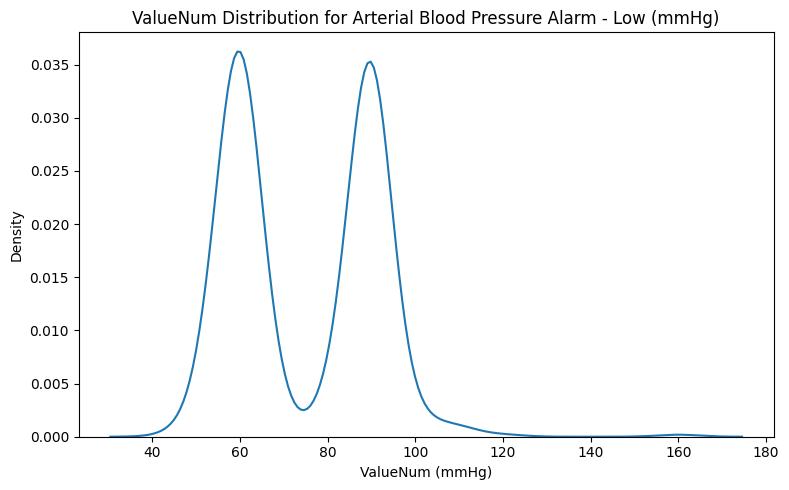

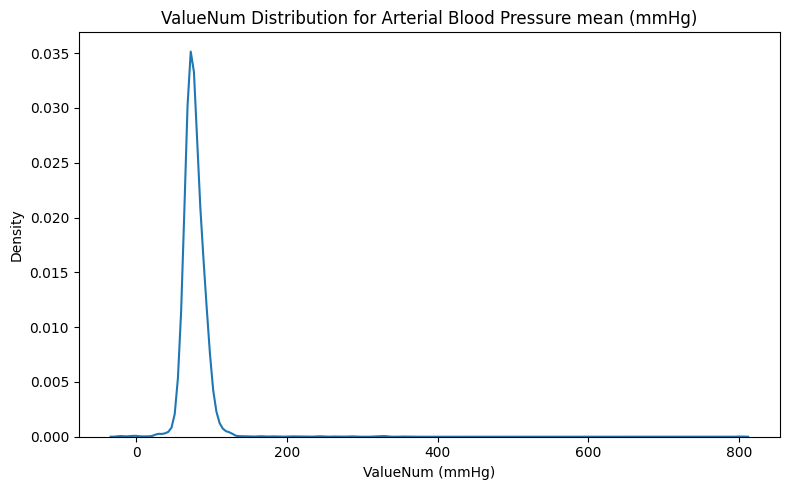

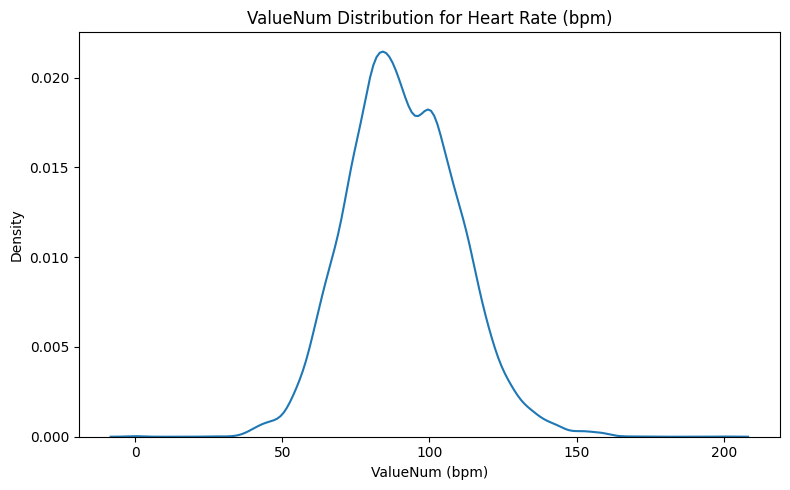

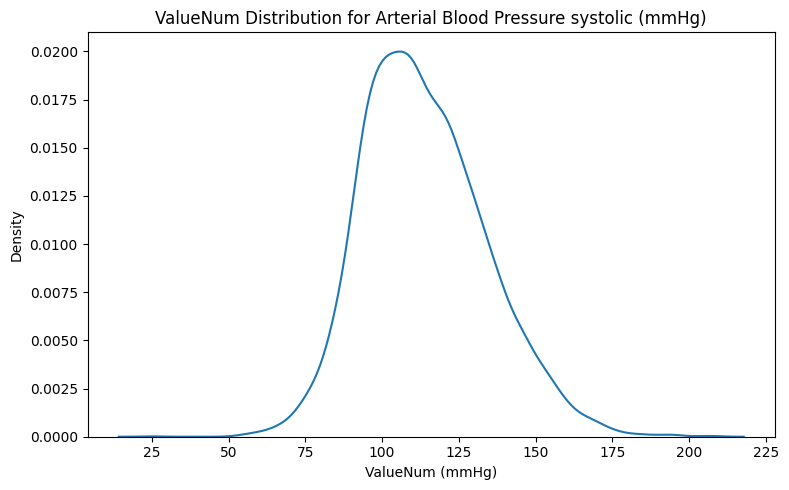

/tmp/ipykernel_2778127/2888883709.py:7: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(subset['valuenum'])


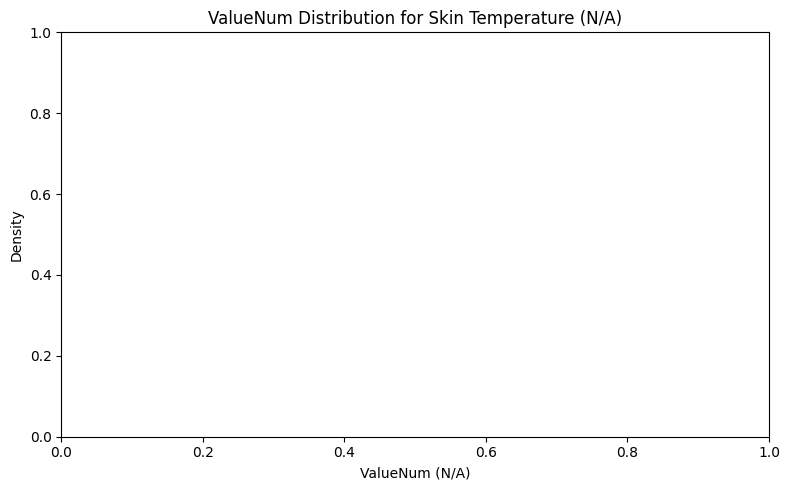

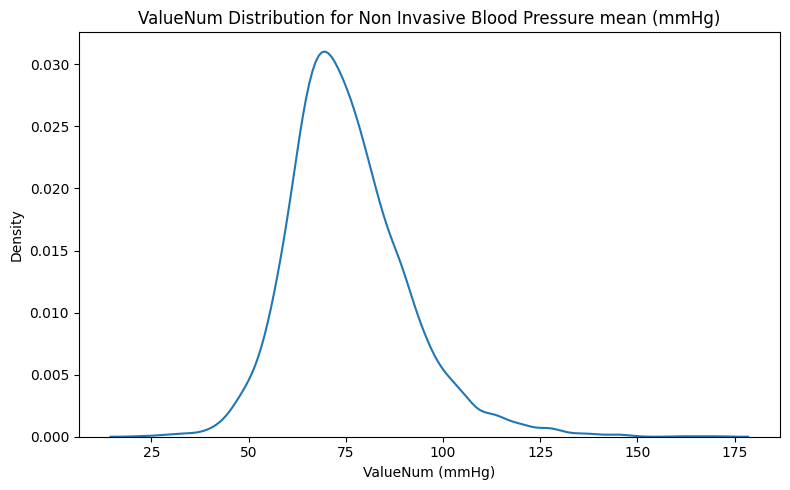

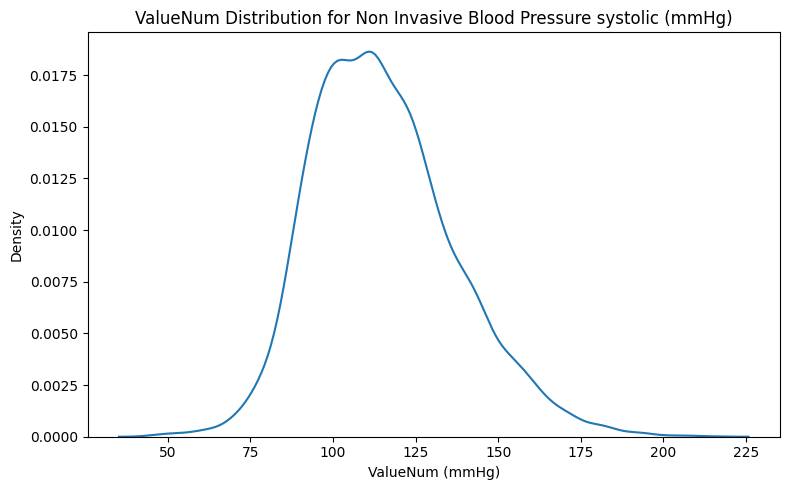

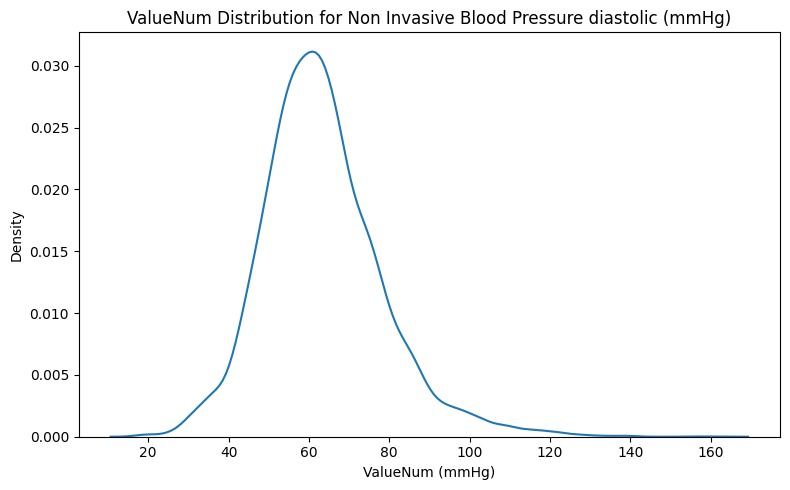

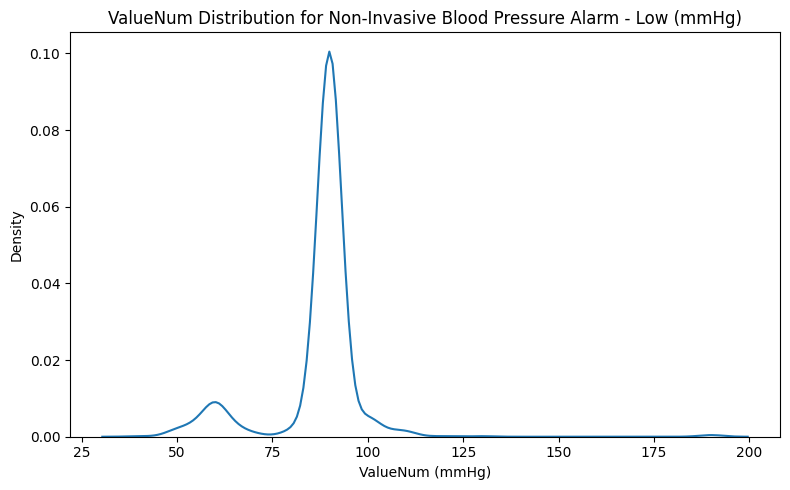

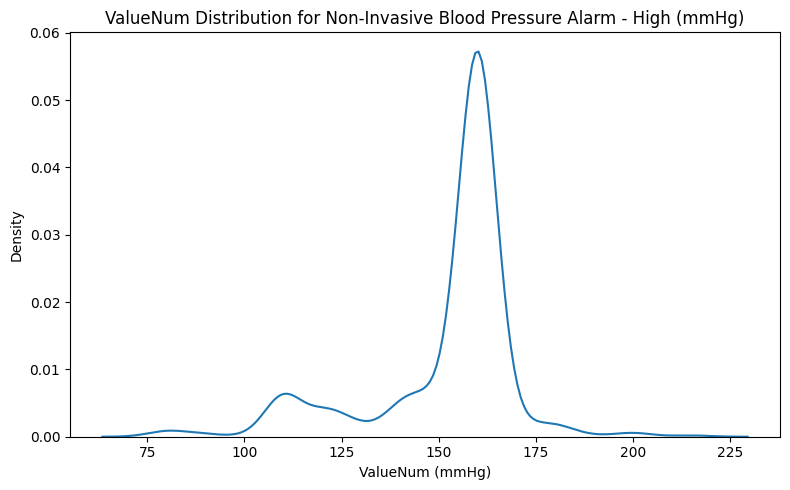

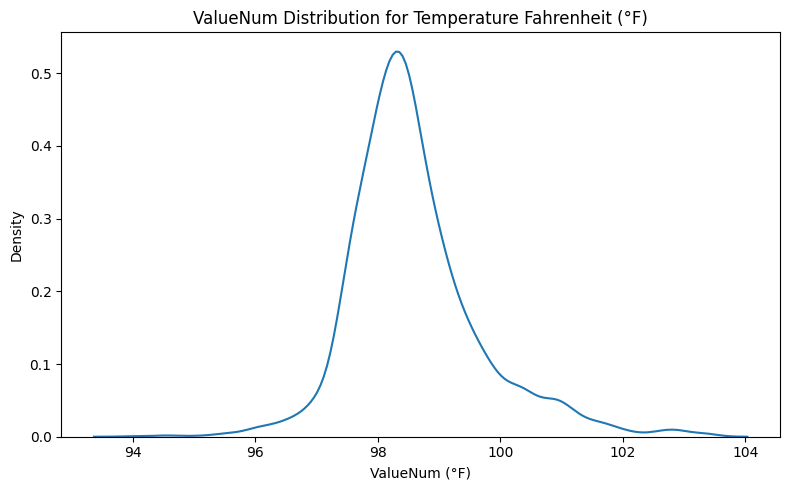

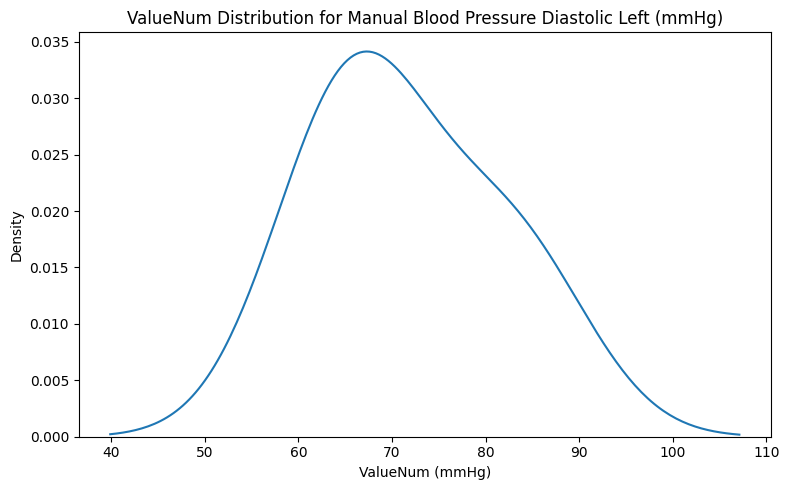

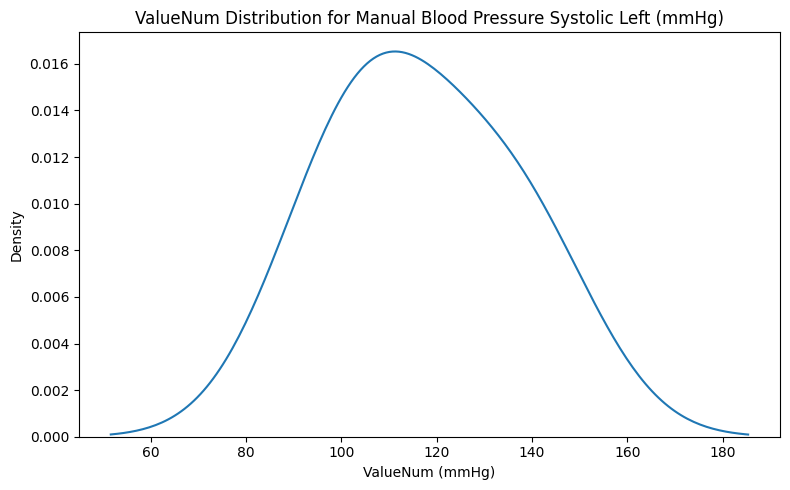

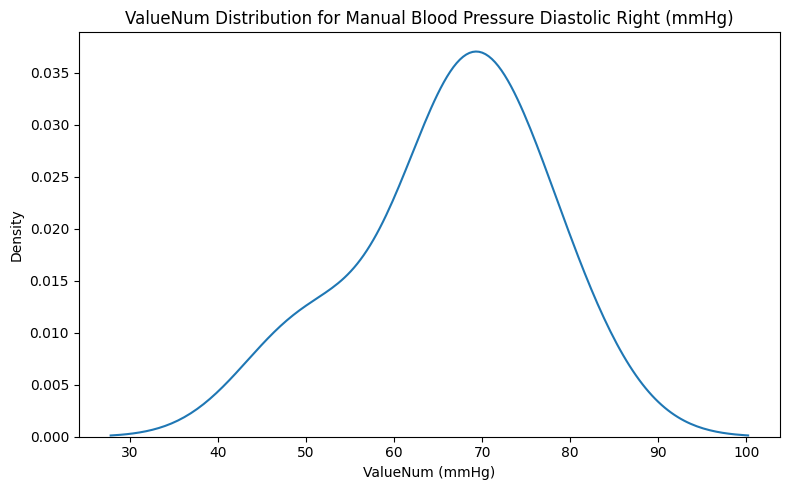

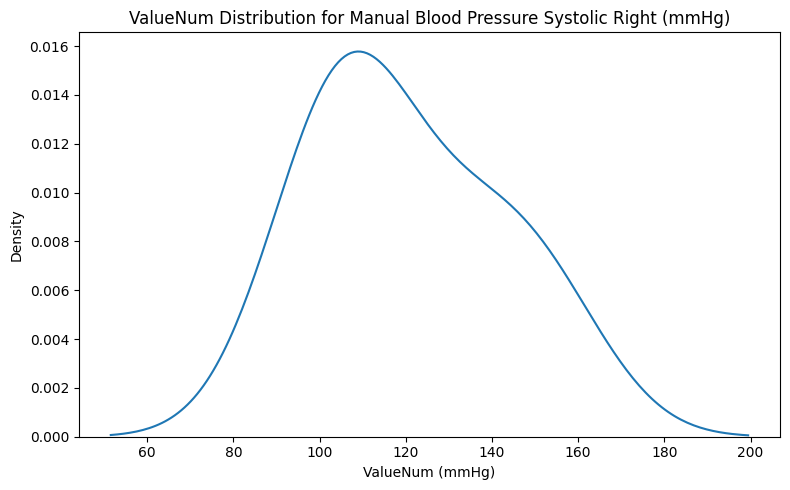

/tmp/ipykernel_2778127/2888883709.py:7: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(subset['valuenum'])


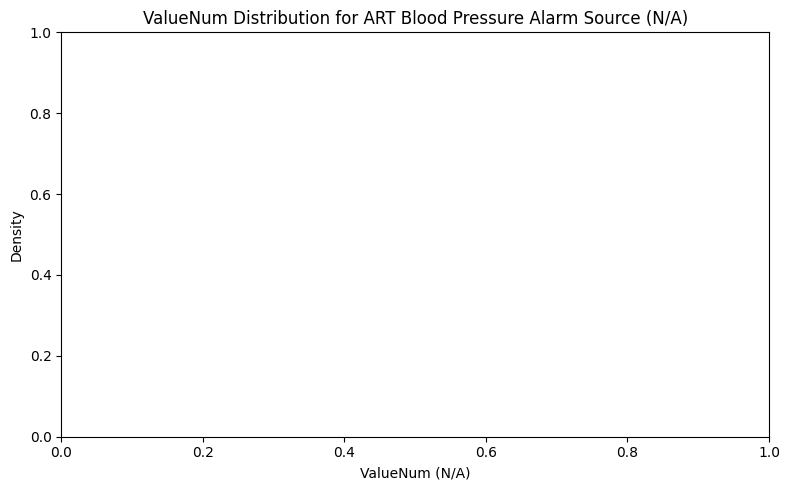

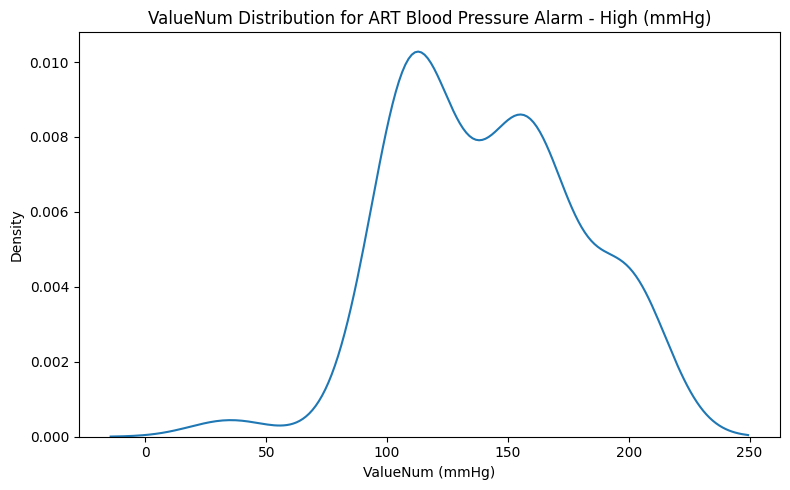

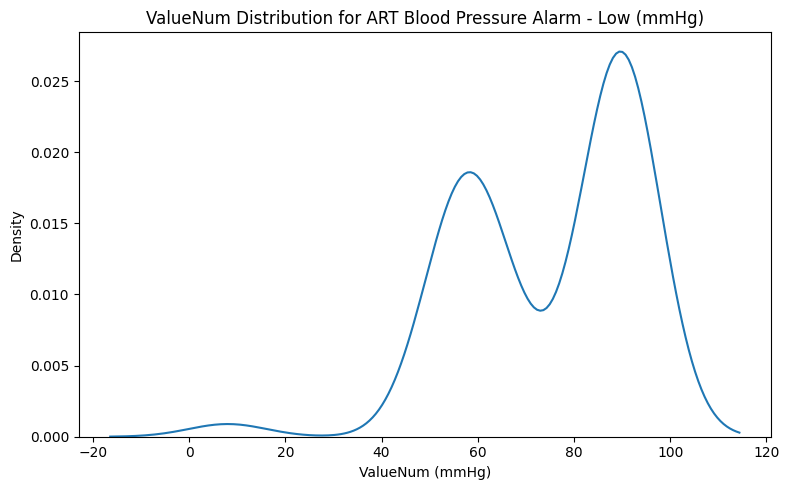

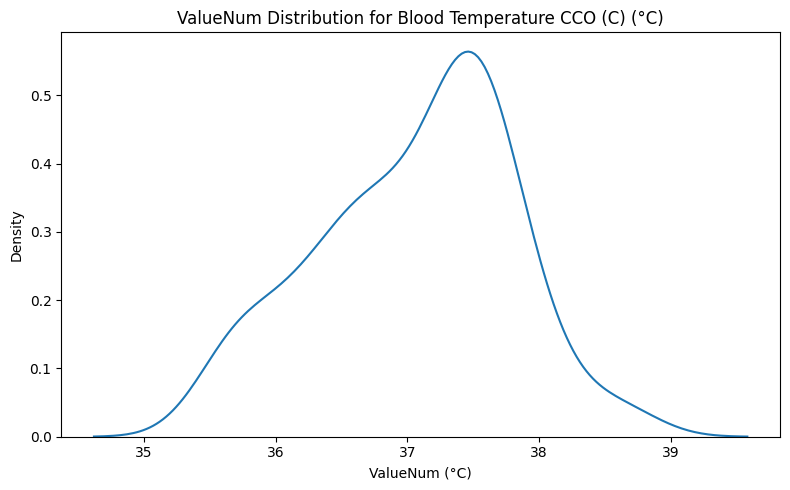

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

for label in vitals_data['label'].unique():
    subset = vitals_data[vitals_data['label'] == label]
    plt.figure(figsize=(8, 5))
    sns.kdeplot(subset['valuenum'])
    valueuom = subset['valueuom'].iloc[0] if 'valueuom' in subset.columns and not subset['valueuom'].isnull().all() else 'N/A'
    plt.title(f'ValueNum Distribution for {label} ({valueuom})')
    plt.xlabel(f'ValueNum ({valueuom})')
    plt.ylabel('Density')
    plt.tight_layout()
    plt.show()

#Data Pre-processing

In [ ]:
#pivot the data so that each label becomes a separate column
vitals_pivot = vitals_data.pivot_table(index=['subject_id', 'hadm_id'], columns='label', values='valuenum', aggfunc='mean').reset_index()

#merge with demographic features
demographics = vitals_data[['subject_id', 'hadm_id', 'gender', 'anchor_age', 'admission_type', 'hospital_expire_flag']].drop_duplicates()
vitals_data = pd.merge(vitals_pivot, demographics, on=['subject_id', 'hadm_id'], how='left')


In [ ]:
print(vitals_data['gender'].unique())

['F' 'M']


In [ ]:
print(vitals_data['admission_type'].unique())

['EW EMER.' 'DIRECT EMER.' 'URGENT' 'SURGICAL SAME DAY ADMISSION'
 'OBSERVATION ADMIT' 'ELECTIVE']


In [ ]:
from sklearn.preprocessing import LabelEncoder

#label Encoding for categorical columns
label_encoder = LabelEncoder()
vitals_data['admission_type'] = label_encoder.fit_transform(vitals_data['admission_type'])
vitals_data['gender'] = label_encoder.fit_transform(vitals_data['gender'])

We prefer label encoder rather than one hot encoding since we have have multiple categories in vitals_data['admission_type'] rather than binary values that can be categorized in 0 or 1 like in vitals_data['gender'].

In [ ]:
vitals_data

,subject_id,hadm_id,ART Blood Pressure Alarm - High,ART Blood Pressure Alarm - Low,Arterial Blood Pressure Alarm - High,Arterial Blood Pressure Alarm - Low,Arterial Blood Pressure diastolic,Arterial Blood Pressure mean,Arterial Blood Pressure systolic,Blood Temperature CCO (C),...,Non Invasive Blood Pressure mean,Non Invasive Blood Pressure systolic,Non-Invasive Blood Pressure Alarm - High,Non-Invasive Blood Pressure Alarm - Low,Temperature Celsius,Temperature Fahrenheit,gender,anchor_age,admission_type,hospital_expire_flag
0,10000032,29079034,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,62.300000,88.900000,160.000000,82.500000,NaN,98.966667,0,52,2,0
1,10001217,24597018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,93.500000,136.296296,150.000000,90.000000,NaN,99.066667,0,55,2,0
2,10001217,27703517,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,83.217391,115.869565,150.000000,90.000000,NaN,98.133333,0,55,0,0
3,10001725,25563031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,70.062500,100.406250,160.000000,90.000000,NaN,97.900000,0,46,2,0
4,10002428,20321825,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,63.127660,100.000000,160.000000,90.000000,NaN,98.453846,0,80,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,10039708,24928679,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,76.722222,108.833333,160.000000,90.000000,NaN,98.444444,0,46,3,0
124,10039708,28258130,180.0,90.0,112.5,65.909091,62.060403,76.870536,95.460850,NaN,...,70.374502,92.224000,126.111111,72.222222,NaN,97.437594,0,46,2,0
125,10039831,26924951,NaN,NaN,160.0,93.333333,55.918919,77.621622,117.891892,NaN,...,NaN,133.000000,160.000000,110.000000,NaN,99.808333,0,57,4,0
126,10039997,24294180,160.0,90.0,145.0,113.333333,65.642857,91.142857,141.250000,NaN,...,100.375000,148.125000,160.000000,90.000000,NaN,98.500000,0,67,4,0


In [ ]:
vitals_data.dtypes

subject_id                                    int64
hadm_id                                       int64
ART Blood Pressure Alarm - High             float64
ART Blood Pressure Alarm - Low              float64
Arterial Blood Pressure Alarm - High        float64
Arterial Blood Pressure Alarm - Low         float64
Arterial Blood Pressure diastolic           float64
Arterial Blood Pressure mean                float64
Arterial Blood Pressure systolic            float64
Blood Temperature CCO (C)                   float64
Heart Rate                                  float64
Heart Rate Alarm - Low                      float64
Heart rate Alarm - High                     float64
Manual Blood Pressure Diastolic Left        float64
Manual Blood Pressure Diastolic Right       float64
Manual Blood Pressure Systolic Left         float64
Manual Blood Pressure Systolic Right        float64
Non Invasive Blood Pressure diastolic       float64
Non Invasive Blood Pressure mean            float64
Non Invasive

Now we deal with the missing values. We first drop columns that have more than 10% missing values, and then impute the other columns with missing values.

In [ ]:
#calculate missing percentage for each column
missing_percentage = vitals_data.isnull().mean() * 100

missing_values = vitals_data.isnull().sum()
print("Missing Values before dropping columns:")
print(missing_values)

#drop columns with more than 10% missing values
columns_to_drop = missing_percentage[missing_percentage > 10].index
print("Columns to drop: ", columns_to_drop)
vitals_data.drop(columns=columns_to_drop, inplace=True)

#print missing values before imputation
missing_values = vitals_data.isnull().sum()
print("Missing Values after dropping columns:")
print(missing_values)

#impute columns with less than 10% missing values using median
imputer = SimpleImputer(strategy='median')
numerical_columns = vitals_data.select_dtypes(include=['float64', 'int64']).columns
vitals_data[numerical_columns] = imputer.fit_transform(vitals_data[numerical_columns])

#print missing values after imputation
missing_values = vitals_data.isnull().sum()
print("Missing Values after Imputation:")
print(missing_values)



Missing Values before dropping columns:
subject_id                                    0
hadm_id                                       0
ART Blood Pressure Alarm - High             106
ART Blood Pressure Alarm - Low              106
Arterial Blood Pressure Alarm - High         63
Arterial Blood Pressure Alarm - Low          63
Arterial Blood Pressure diastolic            64
Arterial Blood Pressure mean                 64
Arterial Blood Pressure systolic             64
Blood Temperature CCO (C)                   124
Heart Rate                                    0
Heart Rate Alarm - Low                        0
Heart rate Alarm - High                       0
Manual Blood Pressure Diastolic Left        125
Manual Blood Pressure Diastolic Right       124
Manual Blood Pressure Systolic Left         125
Manual Blood Pressure Systolic Right        124
Non Invasive Blood Pressure diastolic         0
Non Invasive Blood Pressure mean              1
Non Invasive Blood Pressure systolic          0


In [ ]:
vitals_data

,subject_id,hadm_id,Heart Rate,Heart Rate Alarm - Low,Heart rate Alarm - High,Non Invasive Blood Pressure diastolic,Non Invasive Blood Pressure mean,Non Invasive Blood Pressure systolic,Non-Invasive Blood Pressure Alarm - High,Non-Invasive Blood Pressure Alarm - Low,Temperature Fahrenheit,gender,anchor_age,admission_type,hospital_expire_flag
0,10000032.0,29079034.0,96.500000,60.000000,120.000000,54.100000,62.300000,88.900000,160.000000,82.500000,98.966667,0.0,52.0,2.0,0.0
1,10001217.0,24597018.0,93.296296,60.000000,120.000000,81.333333,93.500000,136.296296,150.000000,90.000000,99.066667,0.0,55.0,2.0,0.0
2,10001217.0,27703517.0,79.600000,60.000000,120.000000,73.478261,83.217391,115.869565,150.000000,90.000000,98.133333,0.0,55.0,0.0,0.0
3,10001725.0,25563031.0,79.156250,57.500000,120.000000,61.187500,70.062500,100.406250,160.000000,90.000000,97.900000,0.0,46.0,2.0,0.0
4,10002428.0,20321825.0,98.122449,60.000000,120.000000,51.978723,63.127660,100.000000,160.000000,90.000000,98.453846,0.0,80.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,10039708.0,24928679.0,74.650000,50.000000,130.000000,62.722222,76.722222,108.833333,160.000000,90.000000,98.444444,0.0,46.0,3.0,0.0
124,10039708.0,28258130.0,80.526074,50.303030,127.878788,64.048000,70.374502,92.224000,126.111111,72.222222,97.437594,0.0,46.0,2.0,0.0
125,10039831.0,26924951.0,98.600000,56.666667,120.000000,62.000000,75.956989,133.000000,160.000000,110.000000,99.808333,0.0,57.0,4.0,0.0
126,10039997.0,24294180.0,94.411765,56.666667,123.333333,85.000000,100.375000,148.125000,160.000000,90.000000,98.500000,0.0,67.0,4.0,0.0


##Class-Imbalance Problem

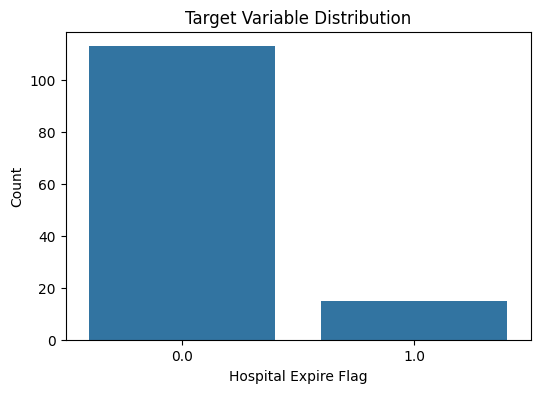

In [ ]:
#target variable distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='hospital_expire_flag', data=vitals_data)
plt.title("Target Variable Distribution")
plt.xlabel("Hospital Expire Flag")
plt.ylabel("Count")
plt.show()

We see that the target variable distribution is very uneven. We can overcome this by upsampling the samples with label 1.0 to balance with the count of label 0.0.

In [ ]:
#handle class imbalance with SMOTE
#X = vitals_data.drop(columns=['hospital_expire_flag'])
X = vitals_data.drop(columns=['hospital_expire_flag', 'subject_id', 'hadm_id'])
y = vitals_data['hospital_expire_flag']

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

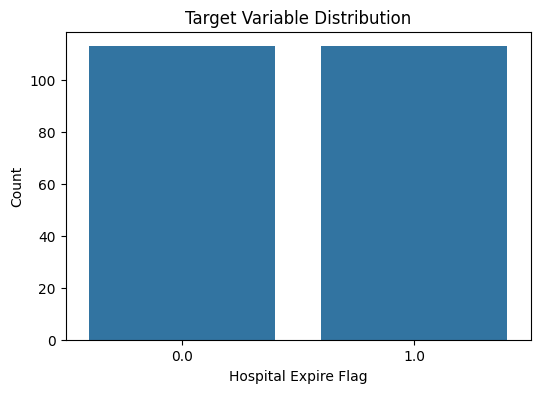

In [ ]:
# Target variable distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=y_resampled)
plt.title("Target Variable Distribution")
plt.xlabel("Hospital Expire Flag")
plt.ylabel("Count")
plt.show()

In [ ]:
#scale numerical features
scaler = StandardScaler()
numerical_columns = vitals_data.select_dtypes(include=['float64', 'int64']).columns
vitals_data[numerical_columns] = scaler.fit_transform(vitals_data[numerical_columns])

print(vitals_data)

     subject_id   hadm_id  Heart Rate  Heart Rate Alarm - Low  \
0     -1.700432  1.326466    0.630292                0.036343   
1     -1.592244 -0.186975    0.384416                0.036343   
2     -1.592244  0.861996   -0.666737                0.036343   
3     -1.545865  0.139219   -0.700793               -0.020961   
4     -1.481683 -1.630578    0.754810                0.036343   
..          ...       ...         ...                     ...   
123    1.921880 -0.074983   -1.046635               -0.192871   
124    1.921880  1.049272   -0.595663               -0.185925   
125    1.933110  0.599098    0.791461               -0.040062   
126    1.948265 -0.289234    0.470025               -0.040062   
127    1.950822  0.960849   -0.022859               -0.175239   

     Heart rate Alarm - High  Non Invasive Blood Pressure diastolic  \
0                  -0.554635                              -1.042478   
1                  -0.554635                               1.807864   
2     

##Correlation Matrix and Correlation of features with target variables

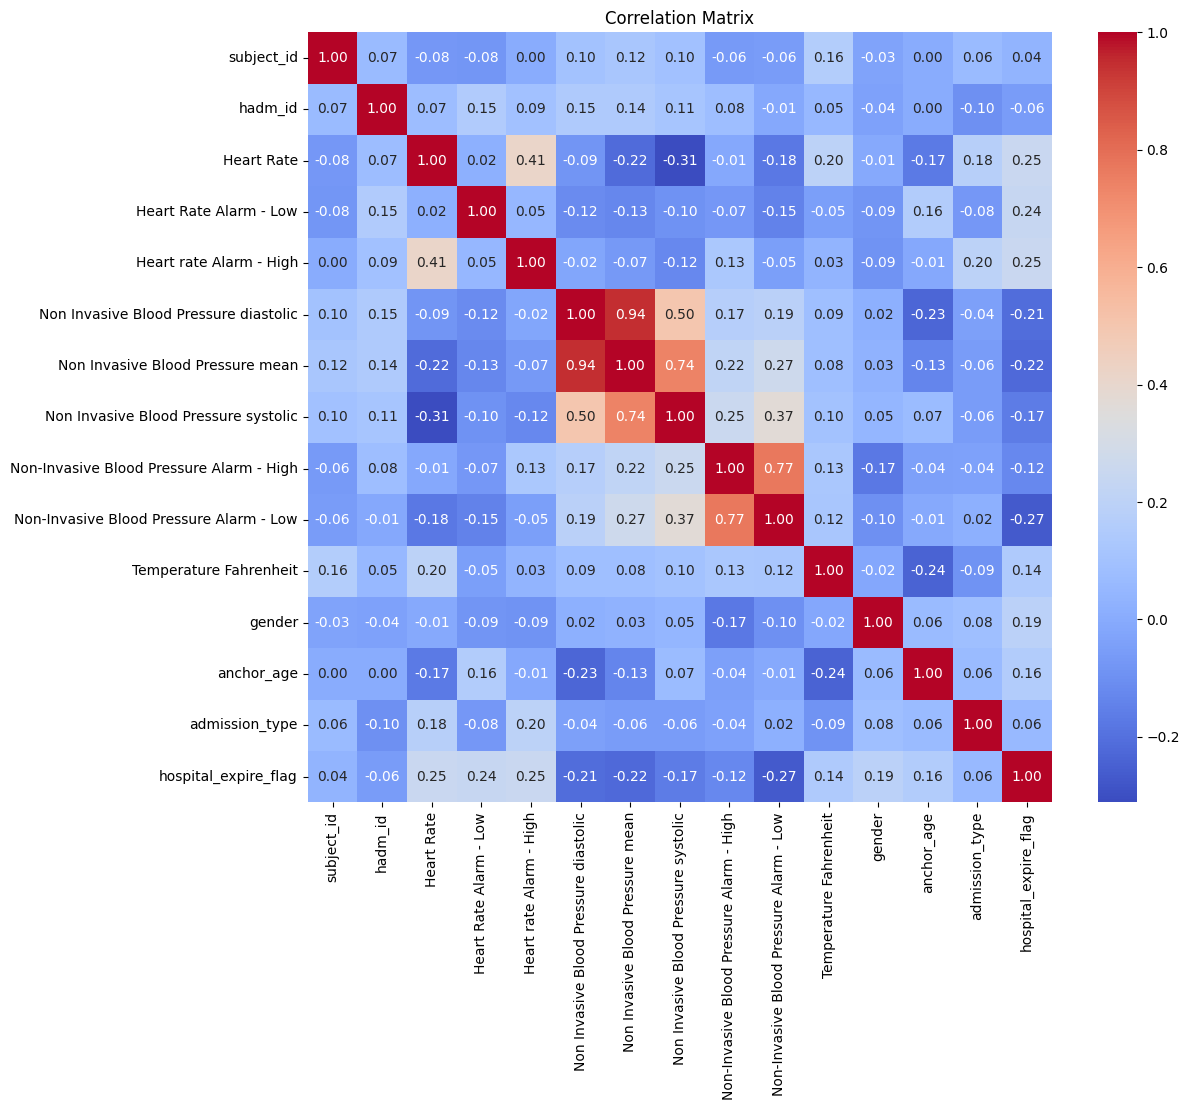

In [ ]:
#correlation Matrix
correlation_matrix = vitals_data.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

We can see some correlation in above matrix as to how Non invasive blood pressure Alarm High and Low are highly correlated to each other.Similarly the Non invasive blood pressure mean is correlated with its diastolic and systolic pressure. We can also see that Heart rate and Non invasive systolic pressure has highest negative correlation with each other.

In [ ]:
#correlation of features with the target variable
correlation_with_target = correlation_matrix['hospital_expire_flag'].sort_values(ascending=False)
print("Correlation of features with the target variable:")
print(correlation_with_target)

Correlation of features with the target variable:
hospital_expire_flag                        1.000000
Heart rate Alarm - High                     0.251529
Heart Rate                                  0.248072
Heart Rate Alarm - Low                      0.239319
gender                                      0.190723
anchor_age                                  0.159031
Temperature Fahrenheit                      0.144433
admission_type                              0.058442
subject_id                                  0.035984
hadm_id                                    -0.059945
Non-Invasive Blood Pressure Alarm - High   -0.123100
Non Invasive Blood Pressure systolic       -0.167516
Non Invasive Blood Pressure diastolic      -0.210057
Non Invasive Blood Pressure mean           -0.219767
Non-Invasive Blood Pressure Alarm - Low    -0.267524
Name: hospital_expire_flag, dtype: float64


We can see that the hospital_expire_flag is slightly correlated with Heart rate features, and least correlated to Non-Invasive Blood Pressure.

#Random Forest Classifier

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

#training a Random Forest Classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

#predictions and probabilities
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

#print probabilities alongside record index
proba_df = pd.DataFrame({
    'death_probability': y_pred_proba
})

print("Probabilities of death of first five record:")
print(proba_df.head())

Probabilities of death of first five record:
   death_probability
0               0.00
1               0.91
2               0.05
3               0.85
4               0.95


##Evaluation

Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97        35
         1.0       1.00      0.94      0.97        33

    accuracy                           0.97        68
   macro avg       0.97      0.97      0.97        68
weighted avg       0.97      0.97      0.97        68



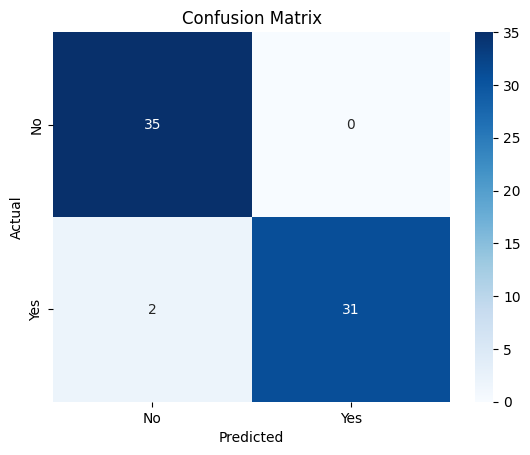

In [ ]:
#evaluation Metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

#confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

We get an accuracy of 97%. And from confusion matrix, we can infer that we have only 2 False Positives.

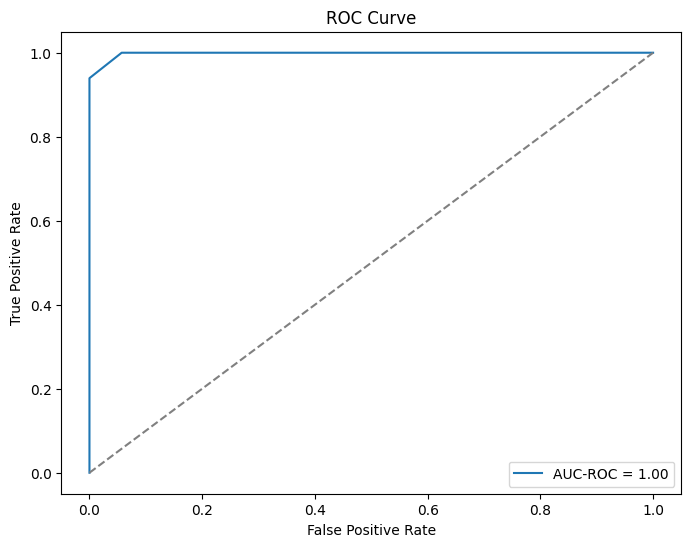

In [ ]:
#AUC-ROC
roc_auc = roc_auc_score(y_test, y_pred_proba)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC-ROC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

#Feature Importance (SHAP Values)

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

In [ ]:
print(shap_values)

[[[-0.01036892  0.01036892]
  [ 0.07426548 -0.07426548]
  [-0.01169273  0.01169273]
  ...
  [ 0.13548489 -0.13548489]
  [ 0.10081895 -0.10081895]
  [ 0.00387856 -0.00387856]]

 [[ 0.00782579 -0.00782579]
  [-0.03840766  0.03840766]
  [-0.08244828  0.08244828]
  ...
  [-0.07636004  0.07636004]
  [-0.05710519  0.05710519]
  [ 0.01814177 -0.01814177]]

 [[ 0.18392289 -0.18392289]
  [-0.00791112  0.00791112]
  [ 0.21123921 -0.21123921]
  ...
  [-0.02994675  0.02994675]
  [-0.03179067  0.03179067]
  [ 0.01544836 -0.01544836]]

 ...

 [[ 0.11320085 -0.11320085]
  [-0.00324988  0.00324988]
  [ 0.11632103 -0.11632103]
  ...
  [ 0.12811711 -0.12811711]
  [-0.01487552  0.01487552]
  [ 0.00954223 -0.00954223]]

 [[-0.02637044  0.02637044]
  [ 0.11349928 -0.11349928]
  [-0.04853551  0.04853551]
  ...
  [ 0.18754617 -0.18754617]
  [-0.03940324  0.03940324]
  [ 0.00993555 -0.00993555]]

 [[-0.02102667  0.02102667]
  [ 0.00558456 -0.00558456]
  [ 0.19792654 -0.19792654]
  ...
  [ 0.20875097 -0.208750

Feature importance (Shap values) for class 0


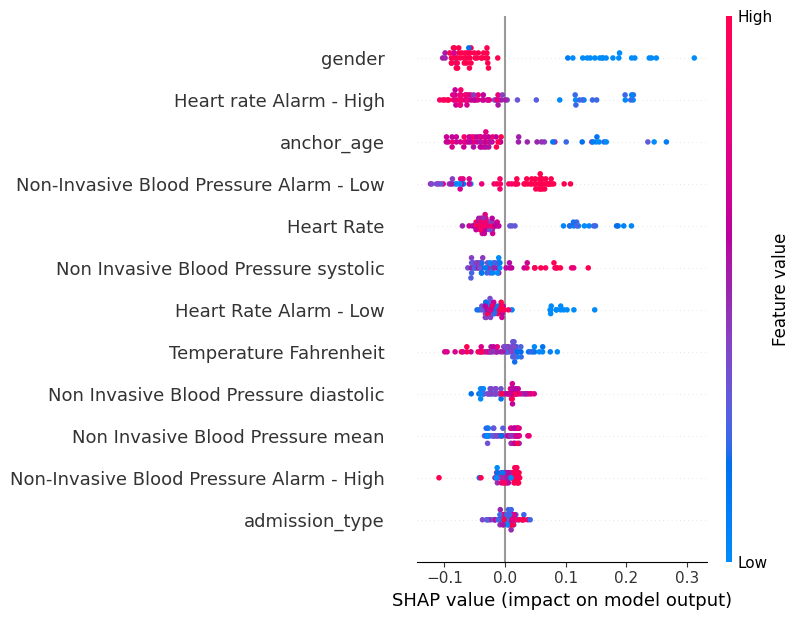

In [ ]:
print("Feature importance (Shap values) for class 0")
shap.summary_plot(shap_values[:,:,0], X_test)

Feature importance (Shap values) for class 1


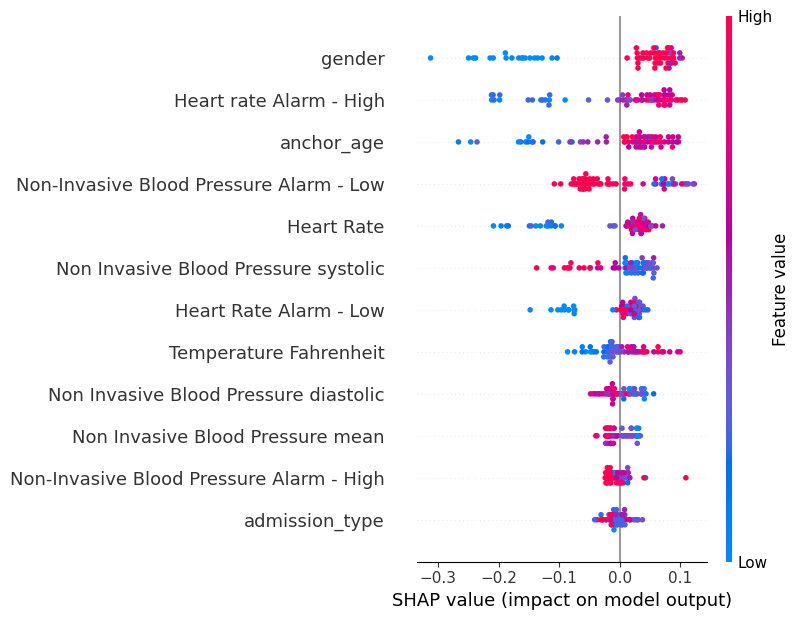

In [ ]:
print("Feature importance (Shap values) for class 1")
shap.summary_plot(shap_values[:,:,1], X_test)

From above graphs we can see that gender, Heart Rate Alarm - High, and anchor_age are the most influential features for predicting either class 0(non-death) or class 1(death). Features lower down the list, such as admission_type and Non-Invasive Blood Pressure Alarm - High, have less impact.